In [1]:
# https://discuss.pytorch.org/t/i-have-3-gpu-why-torch-cuda-device-count-only-return-1/7245/4
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.8.3 (default, May 19 2020, 18:47:26) 
[GCC 7.3.0]
__pyTorch VERSION: 1.7.0
__CUDA VERSION
/usr/bin/sh: 1: nvcc: not found
__CUDNN VERSION: 8003
__Number CUDA Devices: 2
__Devices
Active CUDA Device: GPU 0
Available devices  2
Current cuda device  0


In [2]:
%load_ext autoreload
%autoreload 2

import os
import json
import main
from tqdm import tqdm
import numpy as np
from argparse import ArgumentDefaultsHelpFormatter, ArgumentParser
import matplotlib.pyplot as plt

In [3]:
# arguments
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
args = parser.parse_args('')

args.project_name = 'ContrastiveLearning-SET-Wildcard-Expand-Union-27'
args.data_path = '../Raw_Datasets/SET/WildCardSETidxUnion-3Attr-3Vals-8Pairs-0Train-5120Val-5120Test.json'
args.mode = 'test'
args.resume_checkpoint_dir = 'checkpoints/ContrastiveLearning-SET-Wildcard-Expand-Union-27/20210331-140055-Con;Vec512;L8H8Lk4Hk2;scheduledAdamW72000;17145.88Kparams_runId_337q537l'
args.ckpt_name = 'last.ckpt'
args.runID = '337q537l'
args.gpu = 1
args.approve_before_training = False
args.aml = False
args.dataset_name = None

In [5]:
trainmodule, game_datamodule = main.main(args)

Global seed set to 42


---------data----------
num_attributes : 3
num_attr_vals : 3
key_support_size : 27
N_pairs : 8
union_only : True
max_len_q : 16
len_k : 1
train_gt_idxs length : 0
val_gt_idxs length : 5120
test_gt_idxs length : 5120
train_tokens length : 0
val_tokens length : 5120
test_tokens length : 5120
test_marginal_gt_idxs length : 5120
test_marginal_tokens length : 5120
vocab_size : 74
symbol_vocab_token_lookup : {'(': 64, ')': 65, 'NULL': 66, 'SEP': 67, 'SOS': 68, 'EOS': 69, 'PAD': 70, 'PLH': 71, '|': 72, '!': 73}
vocab_by_property : False
-----------------------
----------hparams----------
seed : 42
batch_size : 1024
max_epochs : 20000000000
val_every_n_epoch : 200
d_model : 512
embed_dropout : 0.0
vec_repr : 512
model : contrastive
d_ff : 1024
N_enc : 8
num_heads : 8
N_enc_key : 4
num_heads_key : 2
attn_wt_tying_scheme : untie_QKVO
attn_wt_dropout : 0.0
heads_dropout : 0.0
pff_dropout : 0.0
representation_pos : 0
dotproduct_bottleneck : True
normalize_dotproduct : False
contrastive_use_infoNCE

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]{0.0048762718215584755, 0.9136935472488403, 1.0, 0.9134174585342407, 4.993302345275879, 0.9443569183349609, 0.8783836364746094, 0.9352416396141052, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 21.93222427368164, 23.215871810913086, 22.706003189086914, 22.828176498413086, 0.05873812362551689, 0.03703700006008148, 0.04541846364736557, 0.06240056827664375, 0.11087169498205185, 0.0499463714659214, 0.09071008116006851, 0.052568454295396805, 0.0831642597913742, 1024.0, 14.881451606750488, 17.997802734375, 18.997222900390625, 19.990631103515625, 19.149999618530273, 20.986791610717773, 0.0001197049641632475, 0.00015322536637540907, 0.00013526853581424803, 0.000156689653522335, 0.0001378392189508304, 0.066554956138134, 0.043448206037282944, 0.00014810333959758282, 0.04757428169250488, nan, 0.07677433639764786, 0.04164484888315201, 0.055481504648923874, 0.039984058588743

## KL Loss Analysis

In [6]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(np.array(x) - np.max(x, axis=-1).reshape(-1, 1))
    return e_x / np.sum(e_x, axis=-1).reshape(-1, 1)

def entropy(x):
    return - np.sum(x * np.log2(x), axis=-1)

top 50th data indices by kl loss [ 968  637 4021  571  263 4502 3281  461 4530 3503 4867 2780  300 1118
 1694 1500 4836 4938 4741 2974 1320 3052 4264 1115 1953 3868 2797 3896
 2238 2083 4952 3747 1458 1920 3364 3987   82 4991 4669 4520 3895 1587
 2822 2339  589  127  449  136 2446 1383]


(array([1361., 1810., 1292.,  424.,  151.,   53.,   17.,    5.,    3.,
           4.]),
 array([0.00049518, 0.00302723, 0.00555929, 0.00809135, 0.0106234 ,
        0.01315546, 0.01568751, 0.01821957, 0.02075163, 0.02328368,
        0.02581574]),
 <BarContainer object of 10 artists>)

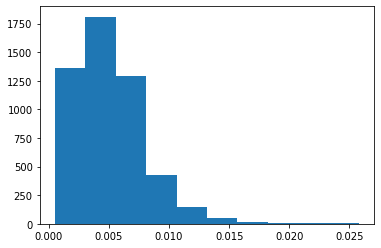

In [7]:
p = 'checkpoints/ContrastiveLearning-SET-Wildcard-Expand-Union-27/20210331-140055-Con;Vec512;L8H8Lk4Hk2;scheduledAdamW72000;17145.88Kparams_runId_337q537l/test_metrics.json'
with open(p, 'r') as f:
    res = json.load(f)
    
full_kl_loss = [row for batch in res['full_kl_loss'] for row in batch]
full_logits = [row for batch in res['full_logits'] for row in batch]
full_probs = softmax(full_logits)


full_kl_loss_sum_row = np.sum(np.array(full_kl_loss), axis=-1)
sorted_indices = np.argsort(full_kl_loss_sum_row)
print('top 50th data indices by kl loss', sorted_indices[:50])

plt.hist(full_kl_loss_sum_row)

In [8]:
game_data = main.load_data(args.data_path)
gt_counts = np.array([len(gt_idxs) for gt_idxs in game_data['test_gt_idxs']])

---------data----------
num_attributes : 3
num_attr_vals : 3
key_support_size : 27
N_pairs : 8
union_only : True
max_len_q : 16
len_k : 1
train_gt_idxs length : 0
val_gt_idxs length : 5120
test_gt_idxs length : 5120
train_tokens length : 0
val_tokens length : 5120
test_tokens length : 5120
test_marginal_gt_idxs length : 5120
test_marginal_tokens length : 5120
vocab_size : 74
symbol_vocab_token_lookup : {'(': 64, ')': 65, 'NULL': 66, 'SEP': 67, 'SOS': 68, 'EOS': 69, 'PAD': 70, 'PLH': 71, '|': 72, '!': 73}
vocab_by_property : False
-----------------------


In [ ]:
print(gt_counts[sorted_indices].tolist()[::-1])

In [ ]:
sorted_indices

In [ ]:
full_logits[14]

In [ ]:
game_data['test_tokens'][373]

In [ ]:
plt.hist(np.exp(full_logits[1207]))

In [ ]:
plt.hist(np.exp(full_probs[1207]))

In [ ]:
plt.hist(full_probs[373])

In [ ]:
plt.bar([str(idx) for idx in gt_idxs_373], full_probs[373][gt_idxs_373])

In [ ]:
plt.bar([str(idx) for idx in not_gt_idxs_373], full_probs[373][not_gt_idxs_373])

In [ ]:
gt_idxs_373 = sorted(game_data['test_gt_idxs'][373])
not_gt_idxs_373 = [i for i in range(27) if not i in gt_idxs_373]

plt.figure(figsize=(20,10))
plt.ylim(0.0, 0.1)

plt.axhline(y=1./gt_counts[373], color='r', linestyle='-')

plt.bar(
    [str(idx) for idx in gt_idxs_373] + [' '] + [str(idx) for idx in not_gt_idxs_373],  
    [1./gt_counts[373]] * 13 + [0.] * 15,
    color='k'
)


In [ ]:
gt_idxs_373 = sorted(game_data['test_gt_idxs'][373])
not_gt_idxs_373 = [i for i in range(27) if not i in gt_idxs_373]

plt.figure(figsize=(20,10))
plt.ylim(0.0, 0.1)

plt.axhline(y=1./gt_counts[373], color='r', linestyle='-')

plt.bar(
    [str(idx) for idx in gt_idxs_373] + [' '] + [str(idx) for idx in not_gt_idxs_373],  
    [1./27] * 13 + [0.] + [1./27] * 14,
    color='k'
)


In [ ]:
gt_idxs_373 = sorted(game_data['test_gt_idxs'][373])
not_gt_idxs_373 = [i for i in range(27) if not i in gt_idxs_373]

plt.figure(figsize=(20,10))
plt.ylim(0.0, 0.1)

plt.axhline(y=1./gt_counts[373], color='r', linestyle='-')

plt.bar(
    [str(idx) for idx in gt_idxs_373] + [' '] + [str(idx) for idx in not_gt_idxs_373],  
    list(full_probs[373][gt_idxs_373]) + [0] + list(full_probs[373][not_gt_idxs_373]),
    color='k'
)


In [ ]:
1 / 13.0

In [ ]:
plt.bar(gt_idxs_373, full_probs[373][gt_idxs_373])

In [ ]:
gt_idxs_373 = sorted(game_data['test_gt_idxs'][373])

In [ ]:
not_gt_idxs_373 = [i for i in range(27) if not i in gt_idxs_373]

In [ ]:
1/13

In [ ]:
gt_counts[373]

In [ ]:
plt.hist(np.exp(full_probs[3834]))

In [9]:
entropy(full_probs[373])

3.7097156625947445

In [ ]:
np.mean(entropy(full_probs))

In [10]:
full_probs_13 = np.array(full_probs)[(gt_counts == 13)]
np.mean(entropy(full_probs_13))

3.711435771119248

In [11]:
full_probs_10_20 = np.array(full_probs)[(gt_counts > 10) & (gt_counts <20)]
np.mean(entropy(full_probs_10_20))

3.97790803259623

In [20]:
full_probs_12_15 = np.array(full_probs)[(gt_counts > 12) & (gt_counts <25)]
np.mean(entropy(full_probs_12_15))

4.155603819998225

## Embedding Analysis

In [15]:
%load_ext autoreload
%autoreload 2

from dataset import BatchFetcher
from metrics import find_nn, analogy, find_cos, find_dotproduct, find_euclidean
from dataraw_sampling import construct_card_idx_lookup

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
cuda_device = trainmodule.model._parameters['key_bias_terms'].device

game_data = main.load_data(args.data_path)
batch_fecther = BatchFetcher(
    raw_data = game_data, device=cuda_device)

---------data----------
num_attributes : 3
num_attr_vals : 3
key_support_size : 27
N_pairs : 8
union_only : True
max_len_q : 16
len_k : 1
train_gt_idxs length : 0
val_gt_idxs length : 5120
test_gt_idxs length : 5120
train_tokens length : 0
val_tokens length : 5120
test_tokens length : 5120
test_marginal_gt_idxs length : 5120
test_marginal_tokens length : 5120
vocab_size : 74
symbol_vocab_token_lookup : {'(': 64, ')': 65, 'NULL': 66, 'SEP': 67, 'SOS': 68, 'EOS': 69, 'PAD': 70, 'PLH': 71, '|': 72, '!': 73}
vocab_by_property : False
-----------------------


In [17]:
queries = [[(0,1,3),(0,0,0)], [(0,1,3),(1,2,0)]]
keys = [[(0,0,0)],[(0,1,0)],[(2,2,2)]]
X_query, X_key = batch_fecther.make_query_batch(X_query_properties=queries, X_key_properties=None, X_key=[i for i in range(game_data['key_support_size'])])
query_repr, key_repr = trainmodule.pull_repr(X_query, X_key)

In [18]:
query_repr

tensor([[ 16.0520,   7.5734,   0.9461,  -2.3650,  -1.6088,  -9.6629,  -1.0611,
           6.2110,   1.5545,  -9.1536,   2.1053,   9.0129,  12.1637,   0.8489,
          -7.5921,  -0.9510,  12.1858,  -5.7816,  -0.7349, -12.5901,   0.1043,
           0.3320, -10.9779,  -0.1230,   5.2522,   3.9918,   6.1307],
        [ 18.7069,  -0.4131,  -2.1271,   2.8310,   3.0094,  -9.6155,  -2.0812,
           9.9261,   0.7530,  -8.7308,   1.5886,   5.2933,  13.3742,   3.2014,
           0.9388,  -0.7415,   7.5635, -14.1845,   7.0459, -16.6190,  -3.9346,
          -7.6409,   0.2007,  -3.9483,   8.3464,  -1.4086,   7.1514]],
       device='cuda:1')

In [19]:
# Do the linear analogy for keys first
key_repr

tensor([[ 0.0796, -0.0752, -0.0946, -0.1759, -0.1973, -0.0511, -0.0078, -0.0213,
         -0.0396, -0.1423,  0.0275,  0.0406, -0.1915,  0.1227, -0.1559,  0.0448,
         -0.0668, -0.0715, -0.0630,  0.1548,  0.2194, -0.0153,  0.1015,  0.2050,
          0.1224, -0.0886, -0.0916],
        [-0.1105,  0.1271, -0.0168,  0.1096, -0.1569,  0.1784,  0.1657,  0.0555,
          0.0832, -0.0355, -0.1577,  0.0570, -0.1655,  0.1863,  0.0719,  0.0632,
          0.1194, -0.0047, -0.1264, -0.1706,  0.1934,  0.0974, -0.1436, -0.0734,
         -0.1678,  0.0156, -0.0255],
        [ 0.0391, -0.0548, -0.1014, -0.1172, -0.1366,  0.1293, -0.1258,  0.1053,
          0.1206,  0.1456,  0.2688, -0.0827,  0.0552,  0.0469,  0.0186,  0.1834,
          0.0498, -0.0990, -0.1653,  0.0606,  0.1213,  0.0900, -0.1319, -0.0397,
          0.1680, -0.0195, -0.0487],
        [-0.1474, -0.1503,  0.0864, -0.0445, -0.0476,  0.1852,  0.0725, -0.0681,
         -0.0272, -0.0397,  0.2288, -0.1121, -0.0085, -0.0052, -0.0668, -0.1025

In [23]:
key_repr_normalized = key_repr / torch.linalg.norm(key_repr, ord=2, dim=-1).view(-1,1)

torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])


(array([ 27.,  54.,   0.,   0.,  54.,  54.,  54.,  54.,  54.,  27.,  81.,
         81., 108.,   0.,   0.,   0.,  27.,   0.,   0.,  27.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  27.]),
 array([-0.08457807, -0.07557318, -0.06656829, -0.0575634 , -0.0485585 ,
        -0.03955361, -0.03054872, -0.02154382, -0.01253893, -0.00353404,
         0.00547085,  0.01447575,  0.02348064,  0.03248553,  0.04149043,
         0.05049532,  0.05950021,  0.0685051 ,  0.07751   ,  0.08651489,
         0.09551978,  0.10452468,  0.11352957,  0.12253446,  0.13153935,
         0.14054425,  0.14954914,  0.15855403,  0.16755893,  0.17656382,
         0.18556871,  0.1945736 ,  0.2035785 ,  0.21258339,  0.22158828,
         0.23059318,  0.23959807,  0.24860296,  0.25760785,  0.26661275,
         0.27561764,  0.28462253,  0.29362743,  0.30263232,  0.31163721,
 

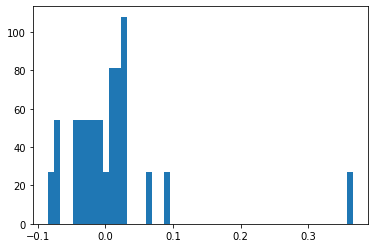

In [52]:
# unnormalized
distances = []

for i in range(27):
    nn_idx, nn_dists = find_nn(v=key_repr[0], Wv=key_repr, similarity_fn=find_dotproduct, k=27)
    distances += nn_dists.tolist()
    
import matplotlib.pyplot as plt
import numpy as np
plt.hist(distances, bins=50)

torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])
torch.Size([27])


(array([ 27.,  27.,  27.,   0.,  54.,  54.,  54.,  54.,  27.,  27.,  27.,
         81., 108.,  81.,   0.,   0.,   0.,  27.,   0.,  27.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  27.]),
 array([-0.24802266, -0.22306221, -0.19810175, -0.17314129, -0.14818084,
        -0.12322038, -0.09825993, -0.07329947, -0.04833902, -0.02337856,
         0.0015819 ,  0.02654235,  0.05150281,  0.07646326,  0.10142372,
         0.12638417,  0.15134463,  0.17630508,  0.20126554,  0.226226  ,
         0.25118645,  0.27614691,  0.30110736,  0.32606782,  0.35102827,
         0.37598873,  0.40094918,  0.42590964,  0.4508701 ,  0.47583055,
         0.50079101,  0.52575146,  0.55071192,  0.57567237,  0.60063283,
         0.62559329,  0.65055374,  0.6755142 ,  0.70047465,  0.72543511,
         0.75039556,  0.77535602,  0.80031647,  0.82527693,  0.85023739,
 

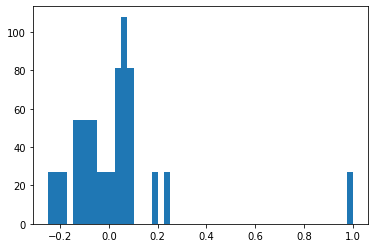

In [55]:
distances = []

for i in range(27):
    nn_idx, nn_dists = find_nn(v=key_repr_normalized[0], Wv=key_repr_normalized, similarity_fn=find_cos, k=27)
    distances += nn_dists.tolist()
    
import matplotlib.pyplot as plt
import numpy as np
plt.hist(distances, bins=50)

In [56]:
np.var(distances), np.mean(distances), np.sum(distances)

(0.04986089455826979, 0.0226185692957154, 16.48893701657653)

In [13]:
card2idx_lookup, idx2card_lookup = construct_card_idx_lookup(game_data['num_attributes'], game_data['num_attr_vals'])


def linear_analogy_by_props(propertiesA, propertiesB, propertiesC, card2idx_lookup, idx2card_lookup):
    keyidxA = card2idx_lookup[propertiesA]
    keyidxB = card2idx_lookup[propertiesB]
    keyidxC = card2idx_lookup[propertiesC]

    print(keyidxA, keyidxB, keyidxC)

    vA = key_repr[keyidxA]
    vB = key_repr[keyidxB]
    vC = key_repr[keyidxC]

    nns_idx, nns_distances = analogy(vA, vB, vC, key_repr, similarity_fn=find_cos, k=None)
    nns_properties = [idx2card_lookup[idx.item()] for idx in nns_idx]
    print(nns_idx, nns_distances)
    print(nns_properties)

In [ ]:
# find a query that 27 got right, but 16 got wrong.



In [14]:
linear_analogy_by_props(
    propertiesA = (2,2,1), 
    propertiesB = (2,2,0), 
    propertiesC = (1,1,1), 
    card2idx_lookup=card2idx_lookup, 
    idx2card_lookup=idx2card_lookup)

25 24 13
torch.Size([27])
tensor([13, 24, 21, 17,  0,  5, 19,  6, 18,  9, 16, 14, 12,  1, 26, 10,  4, 20,
        15, 22, 23,  2,  3,  8, 11,  7, 25], device='cuda:1') tensor([ 5.9432e-01,  5.2089e-01,  1.8108e-01,  1.7092e-01,  1.5072e-01,
         9.9470e-02,  8.8152e-02,  5.8378e-02,  5.0742e-02,  2.9587e-02,
         2.6836e-02,  2.3646e-02, -3.2075e-04, -9.3897e-03, -3.5618e-02,
        -4.0437e-02, -4.1036e-02, -5.6920e-02, -6.9848e-02, -8.6352e-02,
        -1.0769e-01, -1.0988e-01, -1.1066e-01, -1.4922e-01, -1.7888e-01,
        -1.9084e-01, -5.6350e-01], device='cuda:1')
[(1, 1, 1), (2, 2, 0), (2, 1, 0), (1, 2, 2), (0, 0, 0), (0, 1, 2), (2, 0, 1), (0, 2, 0), (2, 0, 0), (1, 0, 0), (1, 2, 1), (1, 1, 2), (1, 1, 0), (0, 0, 1), (2, 2, 2), (1, 0, 1), (0, 1, 1), (2, 0, 2), (1, 2, 0), (2, 1, 1), (2, 1, 2), (0, 0, 2), (0, 1, 0), (0, 2, 2), (1, 0, 2), (0, 2, 1), (2, 2, 1)]


In [15]:
linear_analogy_by_props(
    propertiesA = (0,2,1), 
    propertiesB = (2,2,1), 
    propertiesC = (0,2,2), 
    card2idx_lookup=card2idx_lookup, 
    idx2card_lookup=idx2card_lookup)

7 25 8
torch.Size([27])
tensor([ 8, 25,  6, 11,  3,  1, 23, 12, 20, 24, 26, 14, 22, 18,  0, 19,  5, 13,
         9, 15,  4, 10, 16,  2, 17, 21,  7], device='cuda:1') tensor([ 0.5836,  0.5672,  0.1414,  0.1334,  0.0939,  0.0706,  0.0654,  0.0504,
         0.0499,  0.0454,  0.0359,  0.0162,  0.0008, -0.0127, -0.0160, -0.0195,
        -0.0250, -0.0378, -0.0395, -0.0437, -0.0445, -0.0795, -0.1001, -0.1075,
        -0.1169, -0.1456, -0.4116], device='cuda:1')
[(0, 2, 2), (2, 2, 1), (0, 2, 0), (1, 0, 2), (0, 1, 0), (0, 0, 1), (2, 1, 2), (1, 1, 0), (2, 0, 2), (2, 2, 0), (2, 2, 2), (1, 1, 2), (2, 1, 1), (2, 0, 0), (0, 0, 0), (2, 0, 1), (0, 1, 2), (1, 1, 1), (1, 0, 0), (1, 2, 0), (0, 1, 1), (1, 0, 1), (1, 2, 1), (0, 0, 2), (1, 2, 2), (2, 1, 0), (0, 2, 1)]


In [16]:
linear_analogy_by_props(
    propertiesA = (0,2,1), 
    propertiesB = (2,0,1), 
    propertiesC = (2,2,2), 
    card2idx_lookup=card2idx_lookup, 
    idx2card_lookup=idx2card_lookup)

7 19 26
torch.Size([27])
tensor([19, 26, 24,  0,  5, 21,  6, 13, 12, 10, 20, 23, 22, 14, 25,  2,  1, 11,
         9,  3,  8, 17, 16, 15, 18,  4,  7], device='cuda:1') tensor([ 0.5747,  0.3474,  0.1983,  0.1816,  0.1047,  0.0855,  0.0849,  0.0837,
         0.0797,  0.0752,  0.0469,  0.0442,  0.0374,  0.0358,  0.0024,  0.0024,
        -0.0129, -0.0178, -0.0693, -0.0710, -0.0777, -0.1023, -0.1083, -0.1164,
        -0.1206, -0.1305, -0.5392], device='cuda:1')
[(2, 0, 1), (2, 2, 2), (2, 2, 0), (0, 0, 0), (0, 1, 2), (2, 1, 0), (0, 2, 0), (1, 1, 1), (1, 1, 0), (1, 0, 1), (2, 0, 2), (2, 1, 2), (2, 1, 1), (1, 1, 2), (2, 2, 1), (0, 0, 2), (0, 0, 1), (1, 0, 2), (1, 0, 0), (0, 1, 0), (0, 2, 2), (1, 2, 2), (1, 2, 1), (1, 2, 0), (2, 0, 0), (0, 1, 1), (0, 2, 1)]


In [17]:
linear_analogy_by_props(
    propertiesA = (2,2,1), 
    propertiesB = (2,2,1), 
    propertiesC = (2,2,0), 
    card2idx_lookup=card2idx_lookup, 
    idx2card_lookup=idx2card_lookup)

25 25 24
torch.Size([27])
tensor([24, 12, 21, 26,  3, 25,  0, 10, 19, 16, 20,  9,  2, 18,  5, 15, 13, 14,
        22,  6,  7,  1, 17, 23,  8, 11,  4], device='cuda:1') tensor([ 1.0000,  0.2161,  0.1985,  0.1738,  0.1074,  0.1002,  0.0873,  0.0781,
         0.0746,  0.0638,  0.0627,  0.0606,  0.0483,  0.0294,  0.0180, -0.0106,
        -0.0149, -0.0169, -0.0192, -0.0278, -0.0422, -0.0437, -0.0440, -0.0567,
        -0.0676, -0.0707, -0.0987], device='cuda:1')
[(2, 2, 0), (1, 1, 0), (2, 1, 0), (2, 2, 2), (0, 1, 0), (2, 2, 1), (0, 0, 0), (1, 0, 1), (2, 0, 1), (1, 2, 1), (2, 0, 2), (1, 0, 0), (0, 0, 2), (2, 0, 0), (0, 1, 2), (1, 2, 0), (1, 1, 1), (1, 1, 2), (2, 1, 1), (0, 2, 0), (0, 2, 1), (0, 0, 1), (1, 2, 2), (2, 1, 2), (0, 2, 2), (1, 0, 2), (0, 1, 1)]


In [18]:
linear_analogy_by_props(
    propertiesA = (0,2,1), 
    propertiesB = (2,0,1), 
    propertiesC = (0,2,2), 
    card2idx_lookup=card2idx_lookup, 
    idx2card_lookup=idx2card_lookup)

7 19 8
torch.Size([27])
tensor([19,  8,  1,  5,  0,  6, 11, 23, 14, 20, 22, 24, 13, 18, 15, 16, 21, 10,
         3, 12,  4,  2, 17, 25,  9, 26,  7], device='cuda:1') tensor([ 6.2927e-01,  5.0565e-01,  2.5410e-01,  2.0043e-01,  1.6078e-01,
         1.3743e-01,  1.0221e-01,  7.0698e-02,  6.6436e-02,  5.0487e-02,
         3.1856e-02,  2.9084e-02,  4.8149e-04, -1.0118e-02, -1.8662e-02,
        -3.2290e-02, -3.4671e-02, -5.5464e-02, -5.6432e-02, -7.1705e-02,
        -7.2535e-02, -7.8670e-02, -8.0427e-02, -9.1428e-02, -2.0399e-01,
        -2.3895e-01, -5.0795e-01], device='cuda:1')
[(2, 0, 1), (0, 2, 2), (0, 0, 1), (0, 1, 2), (0, 0, 0), (0, 2, 0), (1, 0, 2), (2, 1, 2), (1, 1, 2), (2, 0, 2), (2, 1, 1), (2, 2, 0), (1, 1, 1), (2, 0, 0), (1, 2, 0), (1, 2, 1), (2, 1, 0), (1, 0, 1), (0, 1, 0), (1, 1, 0), (0, 1, 1), (0, 0, 2), (1, 2, 2), (2, 2, 1), (1, 0, 0), (2, 2, 2), (0, 2, 1)]


In [19]:
linear_analogy_by_props(
    propertiesA = (1,0,1), 
    propertiesB = (2,0,1), 
    propertiesC = (1,2,2), 
    card2idx_lookup=card2idx_lookup, 
    idx2card_lookup=idx2card_lookup)

10 19 17
torch.Size([27])
tensor([17, 19,  1,  0, 20,  5, 13, 21, 18,  8, 16, 15, 11, 22, 23,  2, 24, 14,
        12,  6,  7,  4, 26, 25,  9,  3, 10], device='cuda:1') tensor([ 0.6621,  0.4171,  0.2801,  0.1884,  0.1854,  0.1191,  0.1019,  0.0783,
         0.0723,  0.0655,  0.0533,  0.0518,  0.0305,  0.0282, -0.0138, -0.0203,
        -0.0262, -0.0319, -0.0334, -0.0842, -0.0990, -0.1587, -0.1825, -0.2288,
        -0.2484, -0.2989, -0.5968], device='cuda:1')
[(1, 2, 2), (2, 0, 1), (0, 0, 1), (0, 0, 0), (2, 0, 2), (0, 1, 2), (1, 1, 1), (2, 1, 0), (2, 0, 0), (0, 2, 2), (1, 2, 1), (1, 2, 0), (1, 0, 2), (2, 1, 1), (2, 1, 2), (0, 0, 2), (2, 2, 0), (1, 1, 2), (1, 1, 0), (0, 2, 0), (0, 2, 1), (0, 1, 1), (2, 2, 2), (2, 2, 1), (1, 0, 0), (0, 1, 0), (1, 0, 1)]


In [ ]:
# Look at distance between one card and all the other cards